Config loaded successfully.
Models directory confirmed: c:\Users\Rayyan Khan\Desktop\ORBML2\models
Hyperparameter tuning enabled: True
Loading features data from: ..\data/processed/features_and_labels.parquet
Features data loaded successfully.
Checking for required meta features (28)...
Required meta features found.

Loading trade data from: ..\data/raw/orb_trades.csv

Attempting to load trade data from: ..\data/raw/orb_trades.csv
Loaded trade data: 2051 trades
Processing Entry/Exit times...
Parsed Entry/Exit times successfully.
Processing currency/numeric columns...
Calculated 'Win' column (using Profit > 0.01)
Sample 'Profit' and 'Win' values after cleaning:
    Profit  Win
0   -160.0    0
1    870.0    1
2   -385.0    0
3   -370.0    0
4    865.0    1
5   -275.0    0
6   -875.0    0
7    815.0    1
8   -710.0    0
9   -345.0    0
10  -495.0    0
11  -655.0    0
12  -750.0    0
13  -700.0    0
14 -1050.0    0

Profit column stats:
count    2051.000000
mean      135.302292
std      15

Aligning Features:   0%|          | 0/2051 [00:00<?, ?it/s]


Data prep complete. X shape: (2051, 28), y shape: (2051,)
Target dist:
0    0.595319
1    0.404681
Name: proportion, dtype: float64

Splitting data: Train<=2020-12-31 00:00:00, Val<=2022-12-31 00:00:00
Sizes: Train=1217, Val=371, Test=463

--- Starting Hyperparameter Tuning with Optuna ---
Running Optuna optimization for 50 trials...


  0%|          | 0/50 [00:00<?, ?it/s]

c:\Users\Rayyan Khan\Desktop\ORBML2\venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\Rayyan Khan\Desktop\ORBML2\venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\Rayyan Khan\Desktop\ORBML2\venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\Rayyan Khan\Desktop\ORBML2\venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\Rayyan Khan\Desktop\ORBML2\venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier wa


Optuna study complete. Best trial:
  Value (Avg auc): 0.549958
  Params: 
    n_estimators: 200
    learning_rate: 0.016197439833150414
    num_leaves: 27
    max_depth: 6
    reg_alpha: 0.0026517119349514346
    reg_lambda: 0.00021207062014941494
    min_child_samples: 10
    subsample: 0.8896389706014063
    colsample_bytree: 0.9208395343519149

--- Training FINAL Meta-Labeling Model ---
Starting meta-labeling model training...
Training class counts: Negative (0): 755, Positive (1): 462
Calculated scale_pos_weight for LightGBM: 1.6342
Scaler fitted on training data.
Validation data scaled.
Starting initial LightGBM training (using potentially tuned params)...
Parameters for initial fit: {'random_state': 42, 'scale_pos_weight': np.float64(1.6341991341991342), 'objective': 'binary', 'metric': 'auc', 'verbosity': -1, 'n_estimators': 200, 'learning_rate': 0.016197439833150414, 'num_leaves': 27, 'max_depth': 6, 'reg_alpha': 0.0026517119349514346, 'reg_lambda': 0.00021207062014941494, 'mi

c:\Users\Rayyan Khan\Desktop\ORBML2\venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\Rayyan Khan\Desktop\ORBML2\venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


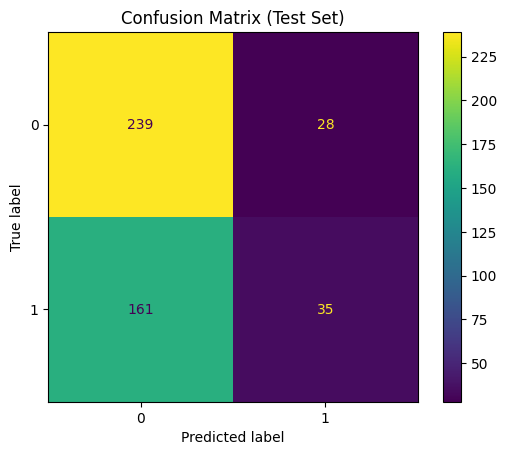

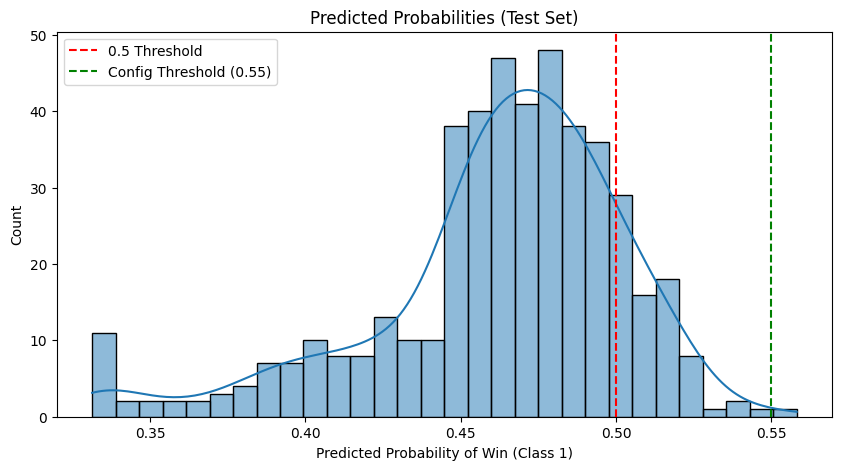


--- Feature Importances (Final Model) ---
                             feature  importance
11                       Volume_lag1          59
16       Dist_from_ORB_Low_Norm_lag1          52
7                        ADX_14_lag1          50
20              ATR_Ratio_14_50_lag1          48
15         ORB_Size_Norm_ATR_50_lag1          47
18  Close_vs_SMA_15_Norm_ATR_14_lag1          44
2                        SMA_15_lag1          43
5                 Volatility_20_lag1          42
19  Close_vs_SMA_20_Norm_ATR_14_lag1          37
22      Interaction_RSI_DistORB_lag1          34
8          MACD_12_26_9_12_26_9_lag1          33
25              Time_Since_Open_lag1          33
10        MACDh_12_26_9_12_26_9_lag1          28
4                 Volume_SMA_20_lag1          28
1                         RSI_7_lag1          26
21          Interaction_Vol_ADX_lag1          25
6                        ROC_10_lag1          22
24                    DayOfWeek_lag1          18
9         MACDs_12_26_9_12

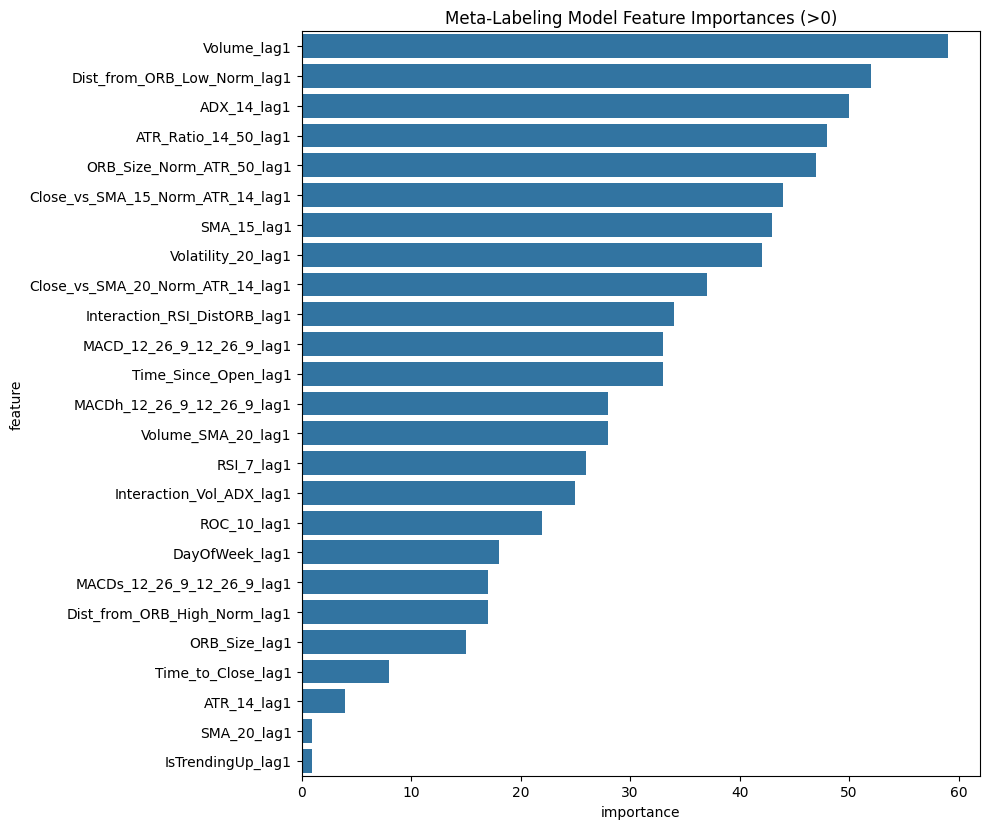

In [1]:
# %% [markdown]
# # 4. Meta-Labeling Model Training
#
# **Purpose:** Prepare data by aligning features (including regime) with historical trade outcomes (Win/Loss). Perform hyperparameter tuning using Optuna and TimeSeriesSplit. Train a final classifier (LightGBM) using best parameters to predict trade success probability. Evaluate the model.

# %%
import pandas as pd
import numpy as np
import yaml
import os
import joblib
import lightgbm as lgb
from sklearn.model_selection import TimeSeriesSplit # Needed for Optuna CV
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
import optuna # Import Optuna
import traceback # For printing full tracebacks on error

# Import custom functions and module
import sys
# Add src directory to path for importing modules
sys.path.append(os.path.abspath(os.path.join('..', 'src')))
from data_processing import load_trade_data
import meta_labeling_model as meta_model_module # Use updated module

# Set display options
pd.set_option('display.max_rows', 100)
optuna.logging.set_verbosity(optuna.logging.WARNING) # Reduce Optuna verbosity

# %% [markdown]
# ## Load Configuration

# %%
CONFIG_PATH = '../config/config.yaml'
try:
    with open(CONFIG_PATH, 'r') as f: config = yaml.safe_load(f)
    print("Config loaded successfully.")
except Exception as e: print(f"ERROR loading config: {e}"); config = None
if config is None: raise ValueError("Failed to load configuration.")

# Define paths
RAW_DATA_DIR = os.path.join('..', config['data_paths']['raw_data_dir'])
PROCESSED_DIR = os.path.join('..', config['data_paths']['processed_dir'])
MODELS_DIR = os.path.abspath(os.path.join('..', config['data_paths']['models_dir']))
TRADE_LOG_FILE = config['data_paths']['trade_log_file']
FEATURES_FILE = os.path.join(PROCESSED_DIR, config['processed_files']['features_labels'])

# Model & HPT parameters
META_PARAMS = config['meta_model_params']
META_FEATURES = META_PARAMS['features']
HPT_CONFIG = config.get('hyperparameter_tuning', {'enabled': False}) # Get HPT config safely

# Data split dates
TRAIN_END_DATE = pd.to_datetime(config['data_split']['train_end'])
VALIDATION_END_DATE = pd.to_datetime(config['data_split']['validation_end'])

os.makedirs(MODELS_DIR, exist_ok=True)
print(f"Models directory confirmed: {MODELS_DIR}")
print(f"Hyperparameter tuning enabled: {HPT_CONFIG.get('enabled', False)}")

# %% [markdown]
# ## Load Data
# Load feature data (features+regimes) and the cleaned trade log.

# %%
print(f"Loading features data from: {FEATURES_FILE}")
features_df = None; trade_df = None # Initialize
try:
    features_df = pd.read_parquet(FEATURES_FILE)
    print("Features data loaded successfully.")
    if not pd.api.types.is_datetime64_any_dtype(features_df.index): features_df.index = pd.to_datetime(features_df.index)
    features_df.sort_index(inplace=True)
    print(f"Checking for required meta features ({len(META_FEATURES)})...")
    missing_cols = [f for f in META_FEATURES if f not in features_df.columns]
    if missing_cols: print(f"Available columns: {features_df.columns.tolist()}"); raise ValueError(f"Missing required features: {missing_cols}")
    print("Required meta features found.")
except Exception as e: print(f"ERROR loading features data: {e}")

print(f"\nLoading trade data from: {os.path.join(RAW_DATA_DIR, TRADE_LOG_FILE)}")
try:
    trade_df = load_trade_data(os.path.join(RAW_DATA_DIR, TRADE_LOG_FILE))
    if trade_df is not None:
        print(f"Trade data loaded successfully. Total trades: {len(trade_df)}")
        # Ensure TradeIndex exists after successful load
        if 'TradeIndex' not in trade_df.columns:
             print("Adding 'TradeIndex' column...")
             trade_df.sort_values(by='Entry time', inplace=True) # Ensure sorted before adding index
             trade_df['TradeIndex'] = range(len(trade_df))
    else:
        print("ERROR: Trade data loading returned None.")
except Exception as e: print(f"ERROR loading trade data: {e}")


# %% [markdown]
# ## Prepare Data for Meta-Labeling
# Align features available *before* trade entry time with Win/Loss outcome.

# %%
X = None; y = None # Initialize
if features_df is not None and trade_df is not None:
    print("\nPreparing data for meta-labeling...")
    trade_features_list = []; trade_outcomes = []; valid_trade_indices = []
    features_df = features_df.sort_index()
    print(f"Aligning features to {len(trade_df)} trades...")
    alignment_errors = 0
    for idx, trade in tqdm(trade_df.iterrows(), total=trade_df.shape[0], desc="Aligning Features"):
        entry_time = trade['Entry time']
        try:
            # Check if 'TradeIndex' column exists before trying to use it
            if 'TradeIndex' not in trade:
                print("Warning: 'TradeIndex' missing in trade row during alignment.")
                alignment_errors += 1
                continue # Skip this trade if index is missing

            insert_pos = features_df.index.searchsorted(entry_time, side='right')
            if insert_pos == 0: continue
            feature_loc_index = insert_pos - 1
            features_at_trade = features_df.iloc[feature_loc_index]
            if features_at_trade.name > entry_time: continue

            feature_values = features_at_trade[META_FEATURES]
            if not feature_values.isnull().any():
                 if np.isfinite(feature_values.values).all():
                      trade_features_list.append(feature_values.values)
                      trade_outcomes.append(trade['Win'])
                      valid_trade_indices.append(trade['TradeIndex']) # Use the trade index

        except KeyError as ke:
            # This specifically catches missing META_FEATURES columns during access
            print(f"KeyError during alignment for trade at {entry_time}: {ke}. Check feature calculation and META_FEATURES list in config.")
            alignment_errors += 1
        except Exception as e:
            alignment_errors += 1
            if alignment_errors < 10: # Print first few unexpected errors
                 print(f"Unexpected error aligning trade at {entry_time}: {e}")
                 # traceback.print_exc() # Uncomment for full traceback if needed

    if alignment_errors > 0: print(f"Total errors during feature alignment: {alignment_errors}")

    if trade_features_list:
        X = pd.DataFrame(trade_features_list, columns=META_FEATURES)
        y = pd.Series(trade_outcomes)
        # Use the valid_trade_indices to get the corresponding entry times
        # Ensure valid_trade_indices is not empty before using .loc
        if valid_trade_indices:
             try:
                 aligned_entry_times = trade_df.set_index('TradeIndex').loc[valid_trade_indices, 'Entry time']
                 if len(aligned_entry_times) == len(X):
                      X.index = aligned_entry_times; y.index = aligned_entry_times
                      print(f"\nData prep complete. X shape: {X.shape}, y shape: {y.shape}")
                      print(f"Target dist:\n{y.value_counts(normalize=True)}")
                      win_prop = y.mean();
                      if win_prop < 0.05 or win_prop > 0.95: print("\n"+"!"*10+" WARNING: EXTREME CLASS IMBALANCE "+"!"*10+f"\nWin Prop: {win_prop:.4f}\n"+"!"*60+"\n")
                 else: print(f"ERR: Len mismatch X:{len(X)},Times:{len(aligned_entry_times)}"); X=None; y=None
             except KeyError as ke_idx:
                 print(f"KeyError retrieving entry times using TradeIndex: {ke_idx}. TradeIndex might not have been added correctly.")
                 X=None; y=None
        else:
             print("ERROR: valid_trade_indices list is empty after alignment loop.")
             X=None; y=None
    else: print("\nERROR: No features aligned. Check data/logic/errors above.")
else: print("\nSkipping data prep (missing features_df or trade_df).")


# %% [markdown]
# ## Split Data Chronologically (Train, Validation, Test)

# %%
X_train, y_train = None, None; X_val, y_val = None, None; X_test, y_test = None, None
if X is not None and y is not None:
    try:
        X.index = pd.to_datetime(X.index); y.index = pd.to_datetime(y.index)
        print(f"\nSplitting data: Train<={TRAIN_END_DATE}, Val<={VALIDATION_END_DATE}")
        train_mask = X.index <= TRAIN_END_DATE; X_train, y_train = X[train_mask], y[train_mask]
        validation_mask = (X.index > TRAIN_END_DATE)&(X.index <= VALIDATION_END_DATE); X_val, y_val = X[validation_mask], y[validation_mask]
        test_mask = X.index > VALIDATION_END_DATE; X_test, y_test = X[test_mask], y[test_mask]
        print(f"Sizes: Train={len(X_train)}, Val={len(X_val)}, Test={len(X_test)}")
        if X_train.empty: print("ERROR: Train set empty!")
        if X_val.empty: print("Warning: Val set empty!")
        if X_test.empty: print("Warning: Test set empty!")
    except Exception as split_err:
         print(f"ERROR during data splitting: {split_err}")
         X_train, y_train, X_val, y_val, X_test, y_test = None, None, None, None, None, None
else: print("\nSkipping data split (X/y None).")


# %% [markdown]
# ## Hyperparameter Tuning with Optuna (Optional)

# %%
best_params = {} # Start with empty dict
study = None # Initialize study object

# Proceed only if HPT enabled and training data exists
if HPT_CONFIG.get('enabled', False) and X_train is not None and not X_train.empty:
    print("\n--- Starting Hyperparameter Tuning with Optuna ---")
    N_TRIALS = HPT_CONFIG.get('n_trials', 50)
    CV_SPLITS = HPT_CONFIG.get('cv_splits', 5)
    OPTUNA_METRIC = HPT_CONFIG.get('metric', 'auc')
    EARLY_STOPPING_ROUNDS_CV = HPT_CONFIG.get('early_stopping_rounds', 20)

    # Define the objective function for Optuna
    def objective(trial):
        # --- Suggest Hyperparameters ---
        params = {
            'objective': 'binary', 'metric': OPTUNA_METRIC, 'verbosity': -1,
            'boosting_type': 'gbdt', 'random_state': 42,
            'n_estimators': trial.suggest_int('n_estimators', 100, 2000, step=100),
            'learning_rate': trial.suggest_float('learning_rate', 1e-3, 0.1, log=True),
            'num_leaves': trial.suggest_int('num_leaves', 10, 60),
            'max_depth': trial.suggest_int('max_depth', 3, 10),
            'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 10.0, log=True),
            'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 10.0, log=True),
            'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
            'subsample': trial.suggest_float('subsample', 0.5, 1.0),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0)
        }

        # --- TimeSeries Cross-Validation ---
        tscv = TimeSeriesSplit(n_splits=CV_SPLITS)
        fold_scores = []
        X_train_np = X_train[META_FEATURES].values; y_train_np = y_train.values

        for fold, (train_idx, val_idx) in enumerate(tscv.split(X_train_np)):
            try: # Add try-except within the fold loop
                X_train_fold, X_val_fold = X_train_np[train_idx], X_train_np[val_idx]
                y_train_fold, y_val_fold = y_train_np[train_idx], y_train_np[val_idx]

                neg_count_fold = (y_train_fold == 0).sum(); pos_count_fold = (y_train_fold == 1).sum()
                scale_pos_weight_fold = (neg_count_fold / pos_count_fold) if (neg_count_fold > 0 and pos_count_fold > 0) else 1
                params['scale_pos_weight'] = scale_pos_weight_fold

                scaler_fold = StandardScaler()
                X_train_fold_scaled = scaler_fold.fit_transform(X_train_fold)
                X_val_fold_scaled = scaler_fold.transform(X_val_fold)

                model_fold = lgb.LGBMClassifier(**params)
                eval_set_fold = [(X_val_fold_scaled, y_val_fold)]
                callbacks_fold = [lgb.early_stopping(EARLY_STOPPING_ROUNDS_CV, verbose=False)]

                model_fold.fit(X_train_fold_scaled, y_train_fold, eval_set=eval_set_fold, eval_metric=OPTUNA_METRIC, callbacks=callbacks_fold)

                y_proba_fold = model_fold.predict_proba(X_val_fold_scaled)[:, 1]
                score = roc_auc_score(y_val_fold, y_proba_fold)
                fold_scores.append(score)
            except Exception as e_fold:
                 print(f"Error in Optuna CV fold {fold}: {e_fold}")
                 # traceback.print_exc() # Uncomment for full detail
                 fold_scores.append(0.0) # Append a bad score if fold fails

        # Return the average score across folds
        avg_score = np.mean(fold_scores) if fold_scores else 0.0 # Handle case where all folds fail
        return avg_score

    # --- Run Optuna Study ---
    try:
        study_direction = HPT_CONFIG.get('direction', 'maximize')
        study = optuna.create_study(direction=study_direction)
        print(f"Running Optuna optimization for {N_TRIALS} trials...")
        study.optimize(objective, n_trials=N_TRIALS, show_progress_bar=True)

        best_params = study.best_params
        print(f"\nOptuna study complete. Best trial:")
        print(f"  Value (Avg {OPTUNA_METRIC}): {study.best_value:.6f}")
        print(f"  Params: ")
        for key, value in best_params.items(): print(f"    {key}: {value}")

    except Exception as e_optuna:
        print(f"ERROR during Optuna hyperparameter tuning: {e_optuna}")
        traceback.print_exc()
        best_params = {}

else:
    if not HPT_CONFIG.get('enabled', False): print("\nHyperparameter tuning skipped (disabled in config).")
    else: print("\nSkipping hyperparameter tuning (training data unavailable).")


# %% [markdown]
# ## Train FINAL Meta-Labeling Model
# Train using the best parameters found by Optuna (or defaults if HPT skipped/failed). Retrain on combined Train+Validation data.

# %%
meta_model = None
meta_scaler = None
model_path = os.path.join(MODELS_DIR, config['model_files']['meta_model'])
scaler_path = os.path.join(MODELS_DIR, config['model_files']['meta_scaler'])

# Proceed only if training data exists
if X_train is not None and y_train is not None and not X_train.empty:
    print("\n--- Training FINAL Meta-Labeling Model ---")
    final_params = best_params.copy() # Use best params from Optuna if available

    try:
        # Call the updated train_meta_labeling_model function from the module
        meta_model, meta_scaler = meta_model_module.train_meta_labeling_model(
            X_train=X_train, y_train=y_train,
            X_val=X_val, y_val=y_val, # Pass validation data
            feature_cols=META_FEATURES,
            model_save_path=model_path,
            scaler_save_path=scaler_path,
            lgbm_params=final_params # Pass the tuned parameters
        )
        if meta_model is not None and meta_scaler is not None: print("\nFinal meta-labeling model training successfully completed.")
        else: print("\nERROR: Final model training function returned None.")

    except Exception as e:
        print(f"ERROR during final meta-labeling model training call: {e}")
        traceback.print_exc()
        meta_model, meta_scaler = None, None

else:
    print("\nSkipping final model training (training data unavailable).")


# %% [markdown]
# ## Evaluate Final Model on Hold-Out Test Set

# %%
# Try loading model/scaler in case training failed but files exist
if meta_model is None or meta_scaler is None:
    print("\nTraining failed or skipped. Loading model/scaler from file for evaluation...")
    try:
        if os.path.exists(model_path) and os.path.exists(scaler_path):
            meta_model = joblib.load(model_path); meta_scaler = joblib.load(scaler_path)
            print("Loaded model and scaler from files.")
        else: print("Could not find saved model/scaler files.")
    except Exception as e: print(f"Error loading model/scaler: {e}")

# Proceed only if model/scaler and test data available
if meta_model is not None and meta_scaler is not None and X_test is not None and y_test is not None and not X_test.empty:
    print("\n--- Evaluating Final Model on TEST Set ---")
    try:
        # Verify features match between scaler and X_test
        if len(meta_scaler.mean_) != len(META_FEATURES) or len(META_FEATURES) != X_test.shape[1]:
             print(f"ERROR: Feature count mismatch! Scaler features: {len(meta_scaler.mean_)}, Config features: {len(META_FEATURES)}, Test data features: {X_test.shape[1]}")
        else:
            X_test_scaled = meta_scaler.transform(X_test[META_FEATURES]) # Ensure correct columns passed
            y_pred_test = meta_model.predict(X_test_scaled)
            y_proba_test = meta_model.predict_proba(X_test_scaled)[:, 1]

            print(f"Test Set Accuracy: {accuracy_score(y_test, y_pred_test):.4f}")
            print(f"Test Set AUC: {roc_auc_score(y_test, y_proba_test):.4f}")
            print("\nTest Set Classification Report:"); print(classification_report(y_test, y_pred_test, zero_division=0))
            print("\nTest Set Confusion Matrix:");
            cm_labels = sorted(y_test.unique());
            if len(cm_labels)<2: cm_labels=[0,1]
            cm = confusion_matrix(y_test, y_pred_test, labels=cm_labels)
            disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=cm_labels); disp.plot(); plt.title("Confusion Matrix (Test Set)"); plt.show()

            # Plot Probability Distribution
            plt.figure(figsize=(10, 5)); sns.histplot(y_proba_test, bins=30, kde=True); plt.title('Predicted Probabilities (Test Set)'); plt.xlabel('Predicted Probability of Win (Class 1)');
            prob_thresh = META_PARAMS.get('probability_threshold', 0.5)
            plt.axvline(0.5, color='red', linestyle='--', label='0.5 Threshold'); plt.axvline(prob_thresh, color='green', linestyle='--', label=f'Config Threshold ({prob_thresh})'); plt.legend(); plt.show()

    except Exception as e: print(f"ERROR during test set evaluation: {e}"); traceback.print_exc()
else: print("\nSkipping test set evaluation (model/scaler/test data unavailable).")


# %% [markdown]
# ## Feature Importance

# %%
if meta_model is not None and hasattr(meta_model, 'feature_importances_'):
    print("\n--- Feature Importances (Final Model) ---")
    try:
        # Use n_features_in_ if available, otherwise fallback
        n_model_features = getattr(meta_model, 'n_features_in_', len(meta_model.feature_importances_))
        if len(META_FEATURES) == n_model_features:
            importances = pd.DataFrame({'feature': META_FEATURES, 'importance': meta_model.feature_importances_}).sort_values('importance', ascending=False)
            print(importances[importances['importance'] > 0]) # Print only features with > 0 importance
            plt.figure(figsize=(10, max(6, len(META_FEATURES)*0.3))); sns.barplot(x='importance', y='feature', data=importances[importances['importance'] > 0]); plt.title('Meta-Labeling Model Feature Importances (>0)'); plt.tight_layout(); plt.show()
        else: print(f"Warning: Feature count mismatch! Config:{len(META_FEATURES)}, Model:{n_model_features}. Cannot display importance accurately.")
    except Exception as e: print(f"Error displaying feature importances: {e}")
else: print("\nSkipping feature importance (model unavailable).")

# %% [markdown]
# ---
# End of Notebook 04
# ---